### 1. 为了熟悉RBF模型，我们先解决一个回归问题。 

 - 数据集：housing.date是一个含有13个特征值和1个结果的506行的数据集
 
 RBF方法： 

1. 选择隐含层的维数，即中心点的个数，J，例如J=50
2. 使用sklearn中KMeans方法把input从13维投射到J维，构建一个N*J的design matrix。
3. 使用最小二乘法直接求出weight。
$ w = (U^TU)^{-1}U^Ty$
4. 用J维的design matrix与求得的weight相乘，与真实值进行对比。
$y\__{rbf} = U*w$

图中可以看出,得到的$y\__{rbf}$近似于真实值y。

In [2]:
pwd

'/Users/yinyujin/Desktop/智源/2020-02-24/RLcode'

110.58049674804326 73.57974005097051


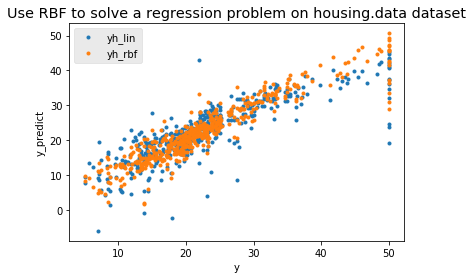

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

rawData = np.genfromtxt('/Users/yinyujin/Desktop/智源/2020-02-24/RLcode/fig/housing.data.txt')
N, pp1 = rawData.shape # 506 14

# Last column is target
X = np.matrix(rawData[:,0:pp1-1])
y = np.matrix(rawData[:,pp1-1]).T

# Solve linear regression, plot target and prediction
w = (np.linalg.inv(X.T*X)) * X.T * y #最小二乘法求w
yh_lin = X*w
plt.plot(y, yh_lin, '.', label='yh_lin')

# J basis functions obtained by k-means clustering
# sigma set to standard deviation of entire data
from sklearn.cluster import KMeans
J = 100;
kmeans = KMeans(n_clusters=J, random_state=0).fit(X) # (100, 13)
sig = np.std(X)

# Construct design matrix
U = np.zeros((N,J))
for i in range(N):
    for j in range(J):
        U[i][j] = np.exp(-(np.linalg.norm(X[i] - kmeans.cluster_centers_[j]))**2/(2*sig**2))
        

# Solve RBF model, predict and plot
w = np.dot(np.dot((np.linalg.inv(np.dot(U.T,U))), U.T), y) 
yh_rbf = np.dot(U,w)

plt.style.use('ggplot')
fig = plt.gcf()
plt.plot(y, yh_rbf, '.', label='yh_rbf')
plt.legend()
plt.title('Use RBF to solve a regression problem on housing.data dataset')
plt.xlabel("y")
plt.ylabel("y_predict")

print(np.linalg.norm(y-yh_lin), np.linalg.norm(y-yh_rbf))

### 2. 用梯度下降法解决上述问题，从随机变量w的猜测开始，并将其与随机数据表示相结合(即随机梯度下降法)。画一个图来表示误差的收敛性。

### Stochastic Gradient Descent

In [1]:
def linear_regression_loss_grad(theta, X, y):
    grad = X.T @ ((X @ theta) - y)
    return grad

def linear_regression_loss(theta, X, y):
    loss = sum( np.power(((X @ theta) - y),2)/2)
    return loss

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
rawData = np.genfromtxt('/Users/yinyujin/Desktop/Reinforcement Learning/1 Reinforcement Learning/Lab/Lab 2/housing.data.txt')
N, pp1 = rawData.shape 

# Last column is target
X = np.matrix(rawData[:, 0:pp1-1])
y = np.matrix(rawData[:, pp1-1]).T  

# Solve linear regression, plot target and prediction
theta = (np.linalg.inv(X.T*X)) * X.T * y 
yh_lin = X*theta   

# RBF 
from sklearn.cluster import KMeans
J = 100;
kmeans = KMeans(n_clusters=J, random_state=0).fit(X) 
sig = np.std(X) 

# Construct design matrix
U = np.zeros((N,J))  
for i in range(N): 
    for j in range(J): 
        U[i][j] = np.exp(-np.linalg.norm(X[i] - kmeans.cluster_centers_[j])/sig)

# stochastic gradient descent, update gradient at every sample, not for whole dataset
w = np.random.rand(J, 1) # initiate theta randomly 

losses = []
min_lr = 0.0002
initial_lr = 0.05
gamma = 0.99

for e in range(0, 10000):
    alpha = max(min_lr, initial_lr*(gamma**(e//10)))  
    index = np.random.permutation(len(U)) 
    u0, y0 = U[index], y[index]  
    for i, u in enumerate(u0):  
        gr = linear_regression_loss_grad(w,u[np.newaxis, :], y0[i]) 
        w -=  alpha * gr 
    loss = linear_regression_loss(w,U, y) 
    losses.append(loss)
    
# Solve RBF model, predict and plot
yh_sgd_rbf = U @ w 

print("norm",np.linalg.norm(y-yh_lin), np.linalg.norm(y-yh_sgd_rbf))


norm 110.58049674804326 115.82804584801765


<Figure size 432x288 with 0 Axes>

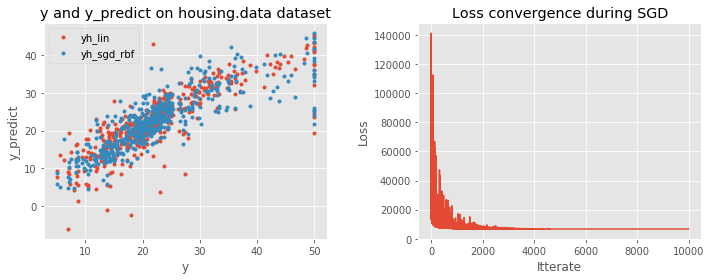

In [25]:
# plot

# Solve linear regression, plot target and prediction
w = (np.linalg.inv(X.T*X)) * X.T * y 
yh_lin = X*w

plt.style.use('ggplot')
fig = plt.gcf()
fig, axes= plt.subplots(nrows=1, ncols=2,figsize=(10,4))
plt.subplot(121)
plt.plot(y, yh_lin, '.', label='yh_lin') 
plt.plot(y, yh_sgd_rbf, '.', label='yh_sgd_rbf')
plt.legend()
plt.xlabel("y")
plt.ylabel("y_predict")
plt.title("y and y_predict on housing.data dataset")

plt.subplot(122)
plt.plot(np.squeeze(np.array(losses))) 
plt.xlabel("Itterate")
plt.ylabel("Loss")
plt.title("Loss convergence during SGD")
plt.tight_layout()
plt.show()